# <center>Actuarial Loss Prediction - Our solution<center>
## <center>Attila Gulyás and Nelvis Fornasin / Boosted Goose<center>
### <center>26.05.2021, Deloitte Advanced Analytics Webinar<center>

The "Actuarial Loss Prediction" Challenge on [Kaggle](https://www.kaggle.com/c/actuarial-loss-estimation) was launched in December 2020, and ran until April 2021.

Aim of the competition was to predict ultimate costs on a single claim basis for worker's compensation insurance. Submissions were scored on the root mean squared error. The data source was a synthetically generated dataset, including among others generic anagraphical data of the workers, a text description of the claim and a first estimate of the ultimate cost.

The competition was hosted by the Actuaries Institute of Australia, Institute and Faculty of Actuaries and the Singapore Actuarial Society. 140 teams took part to the competition, we reached the 2nd place.

# Data

In [16]:
library(tidyverse)
library(lubridate)
library(tidymodels)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(viridis)
library(wordcloud)
options(warn=-1)

In [17]:
train <- read.csv("./actuarial-loss-estimation/train.csv")
head(train,3)

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<int>,<chr>,<int>,<dbl>
1,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203
2,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE LEFT FOREARM,5500,6326.286
3,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949


In [18]:
train %<>% mutate(DateTimeOfAccident = as_datetime(DateTimeOfAccident),
                 DateReported = as_date(DateReported),
                 Gender = as_factor(Gender),
                 MaritalStatus = as_factor(MaritalStatus),
                 PartTimeFullTime = as_factor(PartTimeFullTime),
                 DependentChildren = as.integer(DependentChildren))

Do you want to go through all the features in the summary below? Honestly, it is a little ugly. I think it would be better to make a visual summary. What are your thoughts?

In [19]:
summary(train, digits = 2)

 ClaimNumber        DateTimeOfAccident             DateReported       
 Length:54000       Min.   :1988-01-01 09:00:00   Min.   :1988-01-08  
 Class :character   1st Qu.:1992-06-30 07:00:00   1st Qu.:1992-08-04  
 Mode  :character   Median :1997-01-07 10:00:00   Median :1997-02-16  
                    Mean   :1997-01-03 05:08:31   Mean   :1997-02-11  
                    3rd Qu.:2001-07-09 11:00:00   3rd Qu.:2001-08-25  
                    Max.   :2005-12-31 10:00:00   Max.   :2006-09-23  
      Age     Gender    MaritalStatus DependentChildren DependentsOther 
 Min.   :13   M:41660   M:22516       Min.   :0.00      Min.   :0.0000  
 1st Qu.:23   F:12338   U: 5294       1st Qu.:0.00      1st Qu.:0.0000  
 Median :32   U:    2   S:26161       Median :0.00      Median :0.0000  
 Mean   :34              :   29       Mean   :0.12      Mean   :0.0099  
 3rd Qu.:43                           3rd Qu.:0.00      3rd Qu.:0.0000  
 Max.   :81                           Max.   :9.00      Max.   :5

In [20]:
output <- train %>% 
    mutate(DateReported = as_datetime(DateReported), 
           DateTimeOfAccident = as_datetime(DateTimeOfAccident),
          YearOfAccident = year(DateTimeOfAccident),
          LogUltimateCost = log(UltimateIncurredClaimCost),
          LogInitialCost = log(InitialIncurredCalimsCost))

output_piv <- output  %>% 
    select(LogUltimateCost, LogInitialCost, YearOfAccident)  %>% 
    pivot_longer(c(LogUltimateCost, LogInitialCost), names_to = "Type", values_to = "Amount")

That's a nice one below.

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



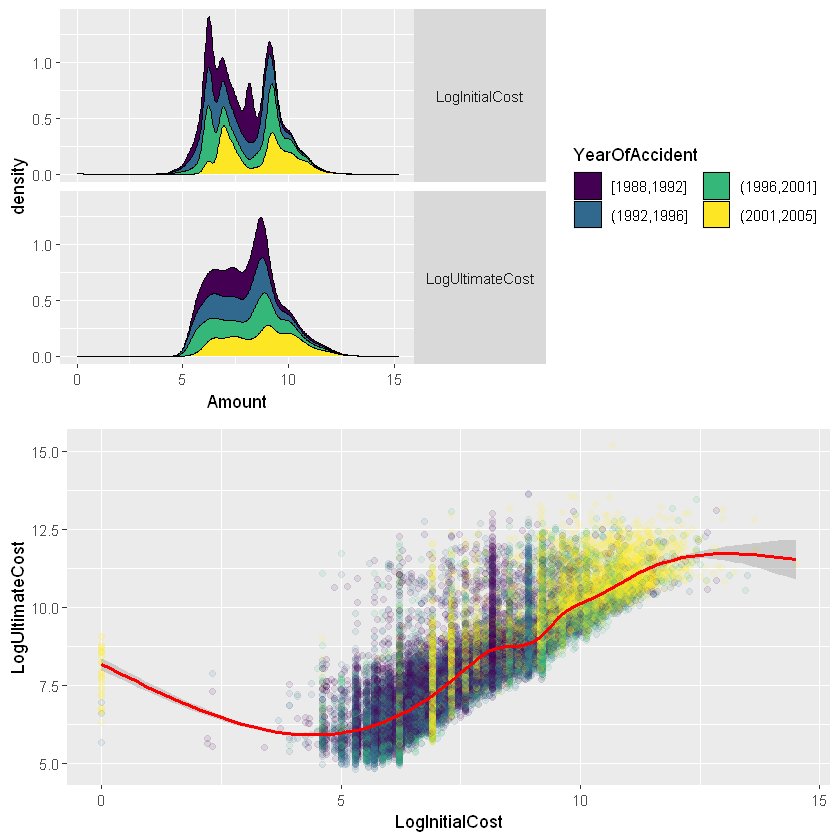

In [27]:
p1 <- ggplot(output_piv, aes(x=Amount, fill = cut_interval(as.numeric(YearOfAccident), 4))) + geom_density(position = "stack") + facet_grid(Type ~ .) + theme(strip.text.y.right = element_text(angle = 0)) +scale_fill_viridis(discrete = TRUE)+ guides(fill=guide_legend(title = "YearOfAccident", ncol=2))
p2 <- ggplot(output, aes(x=LogInitialCost, y=LogUltimateCost)) + geom_point(aes(color = cut_interval(YearOfAccident,4)), alpha = .1) + geom_smooth(color = "red") +scale_color_viridis(discrete = TRUE)+ theme(legend.position = "None") 

grid.arrange(p1, p2, nrow = 2)

In [22]:
output_wc <- output%>% use_series(ClaimDescription) %>% reduce(paste)

In [23]:
words <- str_split(output_wc, pattern = " ")  %>% as.data.frame(col.names = c("Word")) %>% filter(!(Word %in% c("LEFT", "RIGHT"))) %>%  group_by(Word) %>% summarise(Count = n())

In [24]:
output  %>% select(ClaimDescription) %>% head(20)

,ClaimDescription
,<chr>
1,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY
2,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE LEFT FOREARM
3,CUT ON SHARP EDGE CUT LEFT THUMB
4,DIGGING LOWER BACK LOWER BACK STRAIN
5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STRAIN LEFT SIDE OF STOMACH
6,STRUCK HEAD ON HEAD LACERATED HEAD
7,FINGER BRUISED AND SWOLLEN LEFT ARM
8,CLEANING LEFT SHOULDER SPLINTER LEFT HAND
9,JACK SLIPPED CATCHING FINGER CUT LEFT LITTLE FINGER


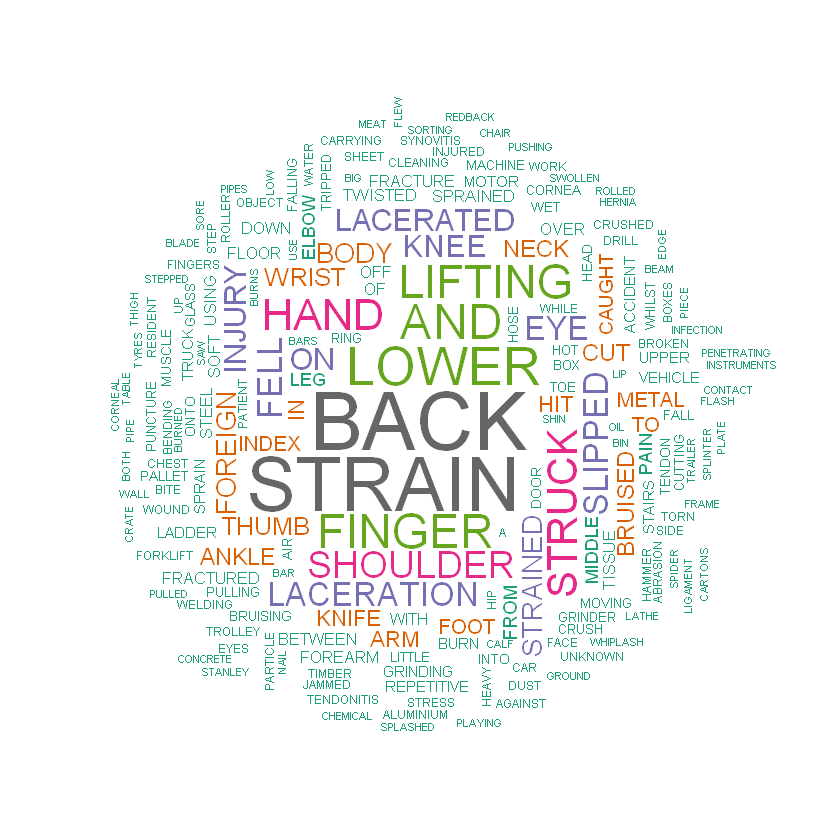

In [25]:
wordcloud(words = words$Word, freq = words$Count, min.freq = 1, max.words=200, 
          random.order=FALSE, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

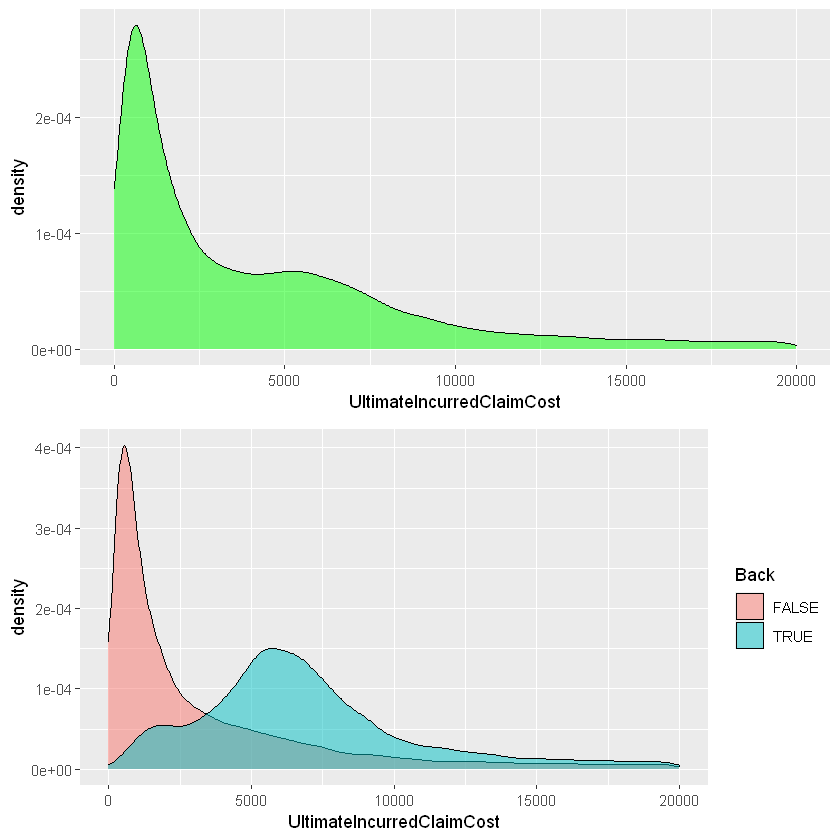

In [26]:
output_b <- output %>% mutate(Back = str_detect(ClaimDescription, "BACK"))
p1 <- ggplot(output_b, aes(x=UltimateIncurredClaimCost)) + geom_density(alpha = 0.5, fill = "green") + scale_x_continuous(limits = c(0, 20000))
p2 <- ggplot(output_b, aes(x=UltimateIncurredClaimCost, fill = Back)) + geom_density(alpha = 0.5) + scale_x_continuous(limits = c(0, 20000))
grid.arrange(p1, p2, nrow = 2)

# Text Analysis

The (synthetically generated) claim descriptions do not offer much in terms of grammatical structure, sometimes barely make sense, e.g. "TO RIGHT LEG RIGHT KNEE".

Our approach to analyse this feature:
- Drop stopwords ("in", "on", ...);
- Lemmatize the words ("feet" and "foot" are mapped to "foot");
- Stem words (Both "laceration" and "lacerated" are mapped to "lacer");
- Cluster and weight words according to ultimate claim cost;
- One hot encoding for most common words.

In the end we OHEncoded roughly 100 words and created 30 clusters.

## Stemming

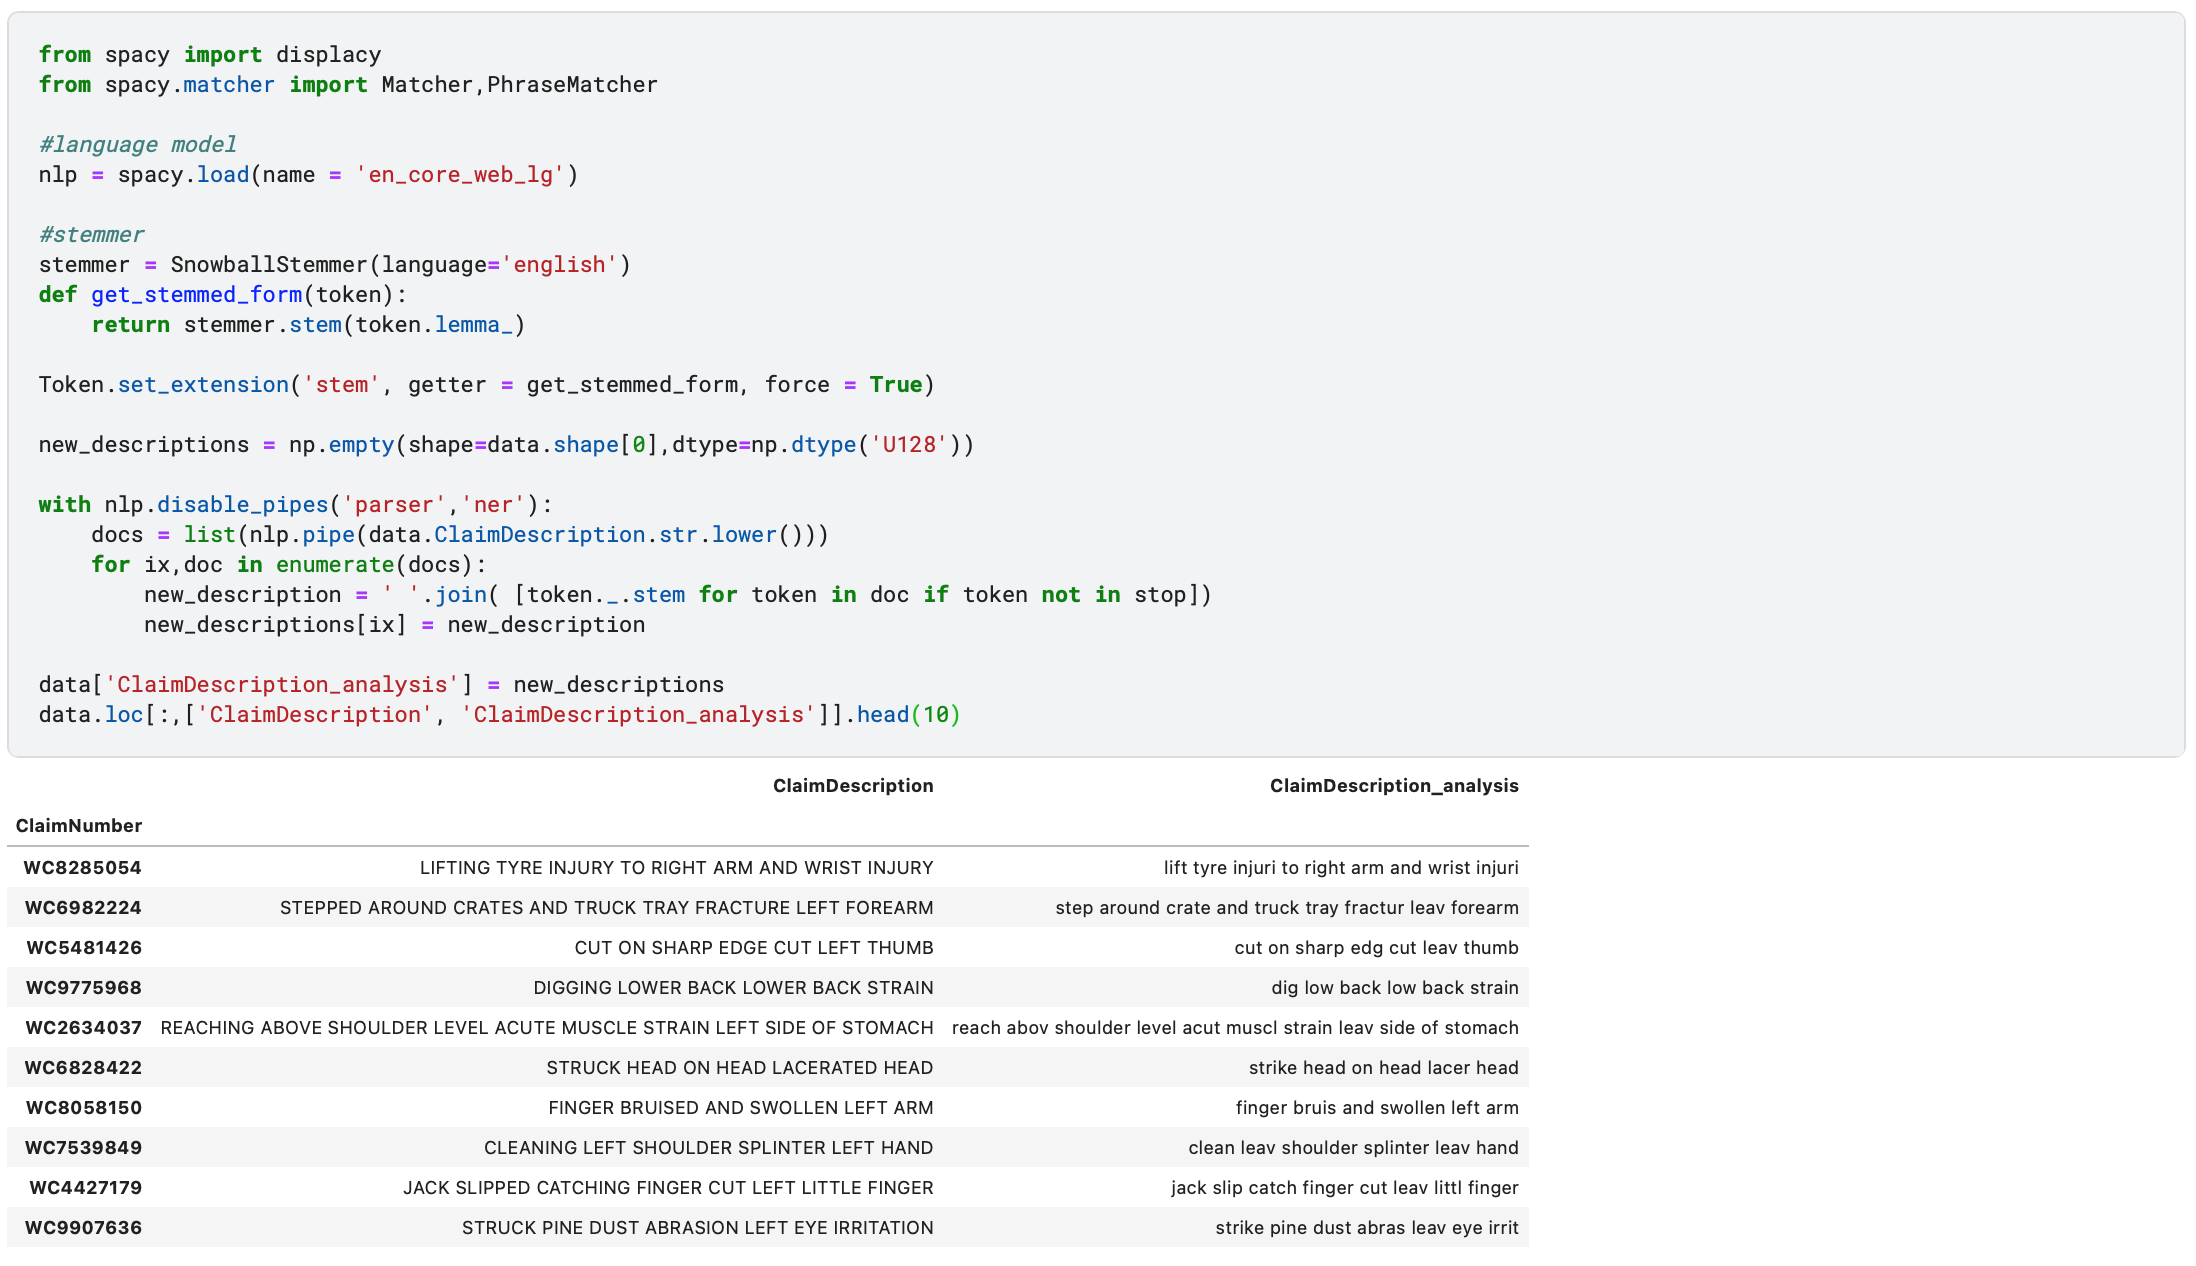

## Weighting

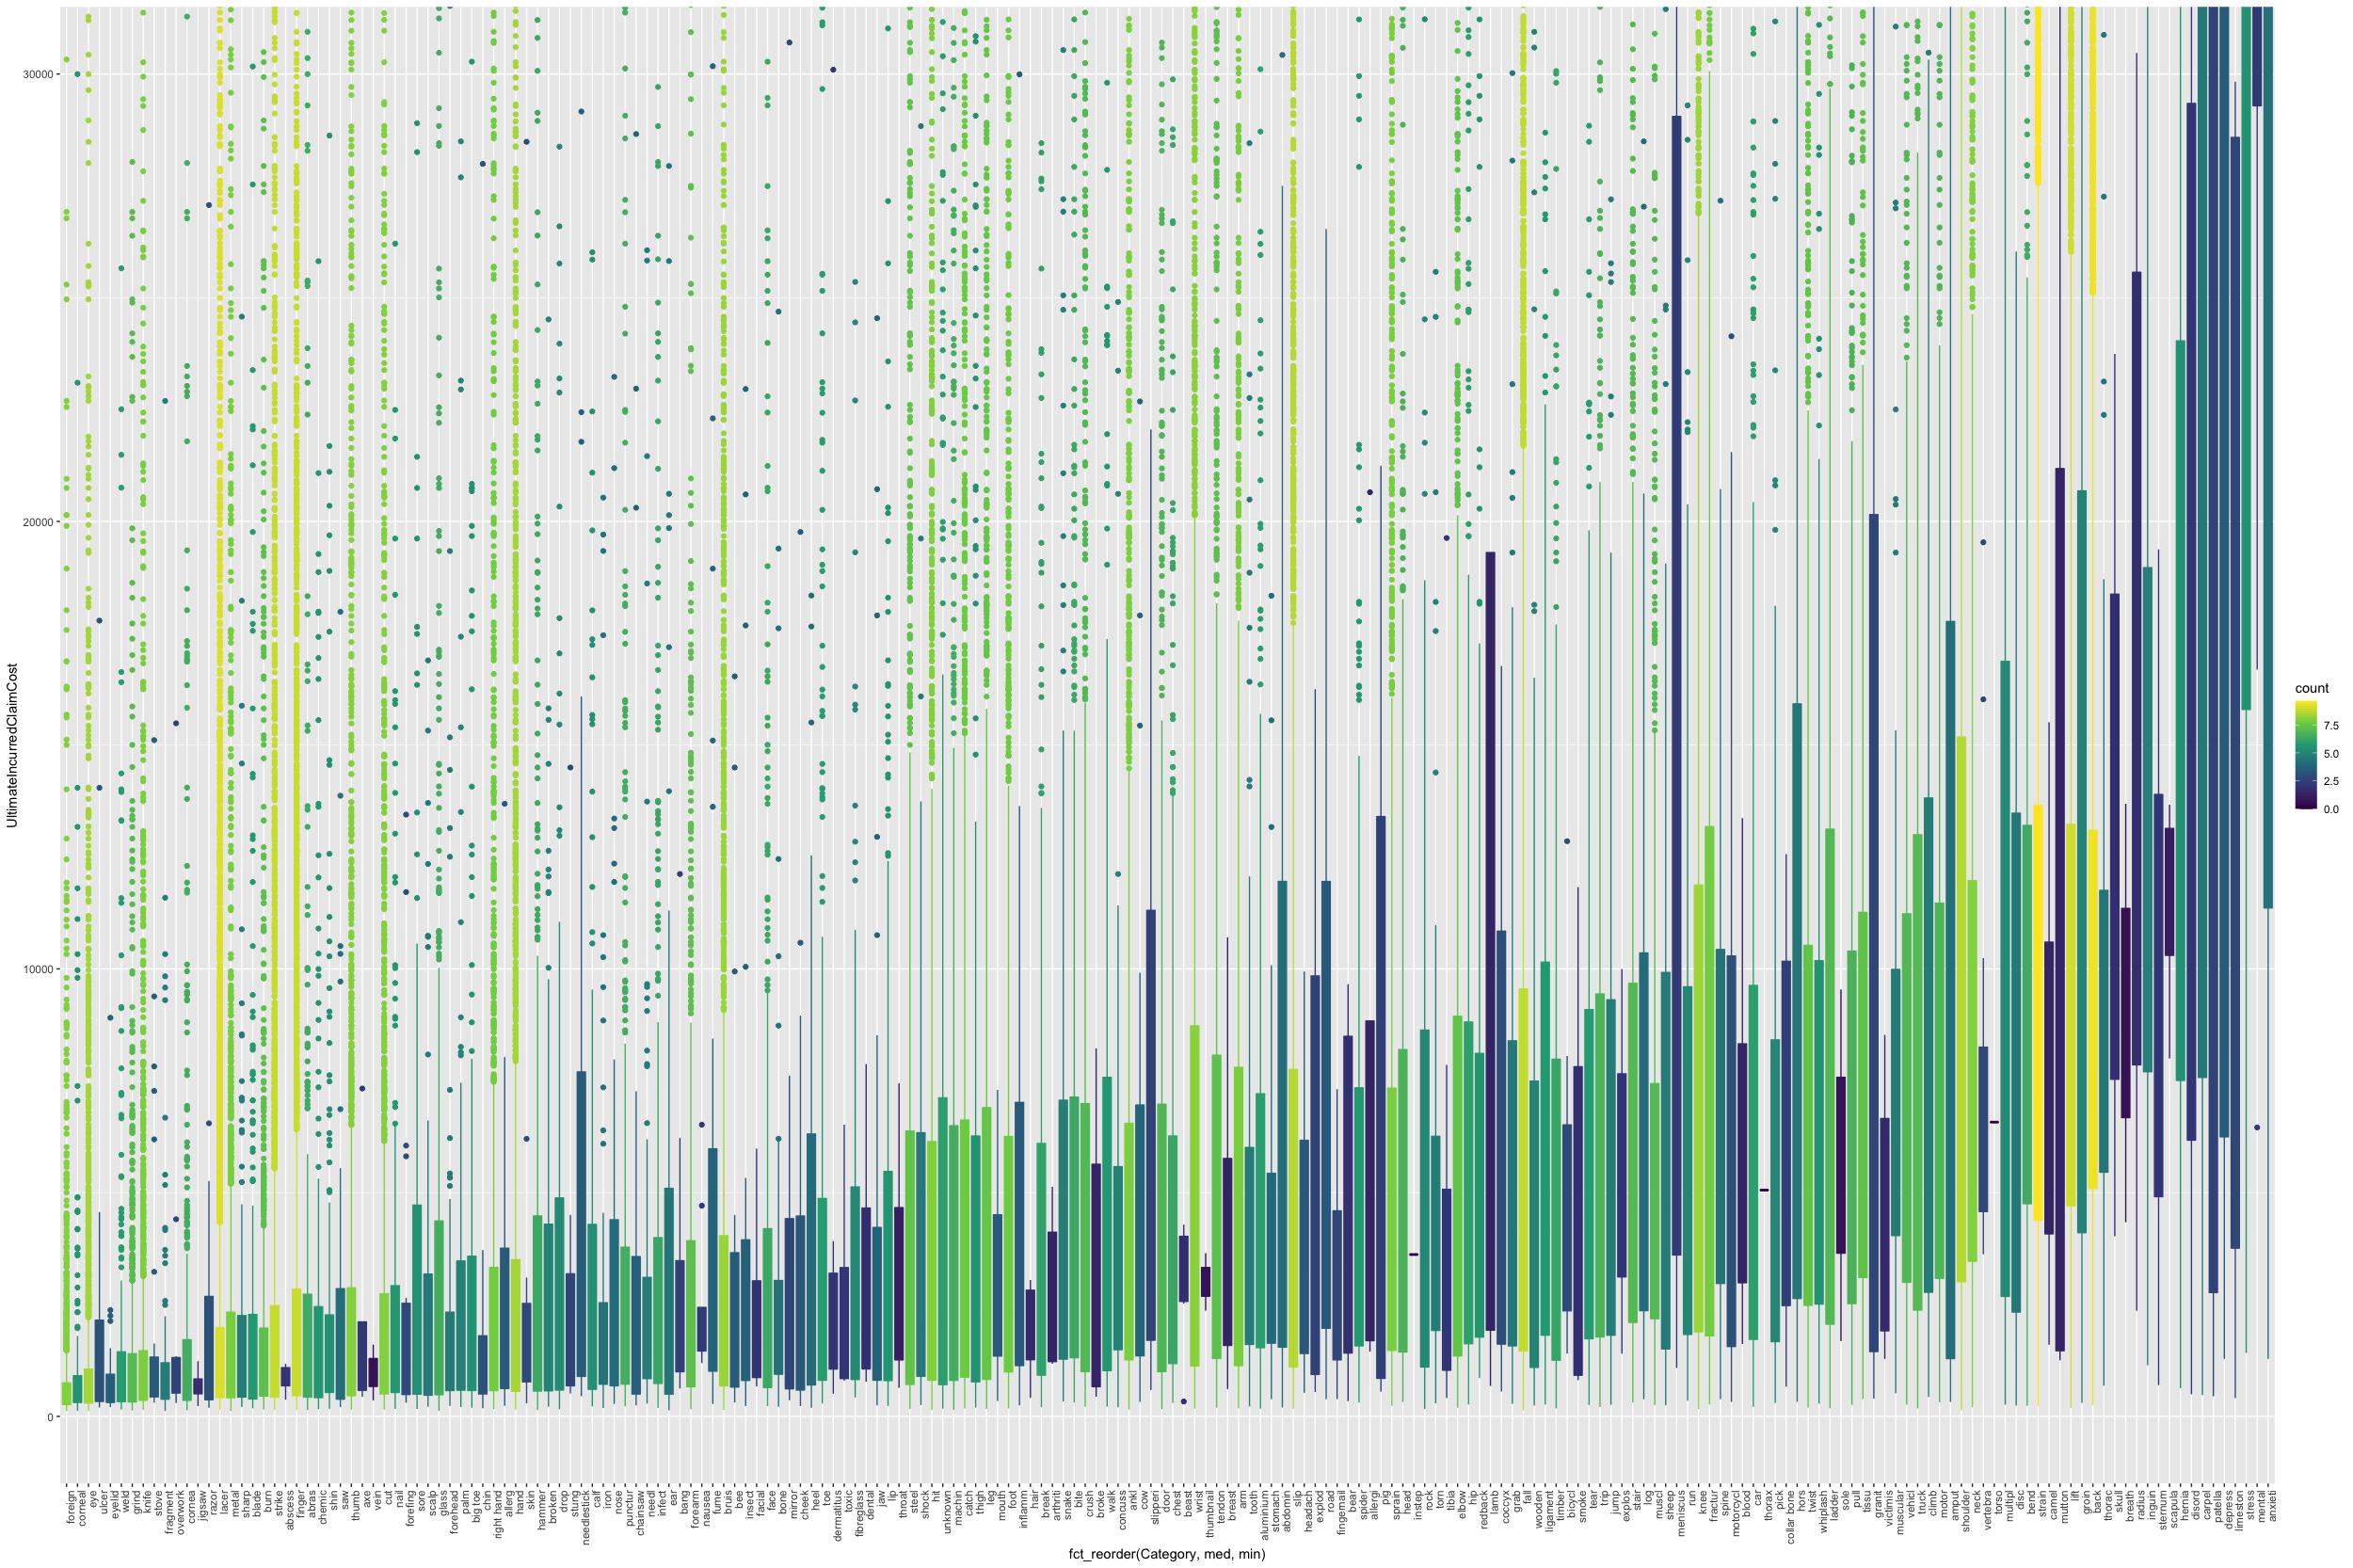

# Model

The final algorithm relied on the following ensemble techniques:
- **Boosting**: gradient boosting using xgboost
- **Bagging**: random forest as base learner
- **Voting**: custom combination of models based on insight

Besides gradient boosted trees, we have experimented with neural networks as well. Specifically, the following implementations were tried: *xgboost*, *lightgbm* and *keras*.

## What is gradient boosting?

Gradient Boosting is an ensemble learning algorithm. It adds predictors sequentially to an ensemble as follows: each new predictor is fit to the residual errors made by the previous predictor. For example, a gradient boosting algorithm consisting of 3 predictors could be described as follows:

1. Fit the 1st predictor on $X,y$. Predict $\hat{y}_1$.
2. Obtain the residuals of the 1st predictor: $y_2=y-\hat{y}_1$. Fit the 2nd predictor on $X,y_2$. Predict $\hat{y}_2$.
3. Obtain the residuals of the 2nd predictor: $y_3 = y - \hat{y}_2$. Fit the 3rd predictor on $X,y_3$. Predict $\hat{y}_3$.
4. Obtain the final estimate by summing the predictions (regression): $\hat{y} = \hat{y}_1 + \hat{y}_2 + \hat{y}_3$.

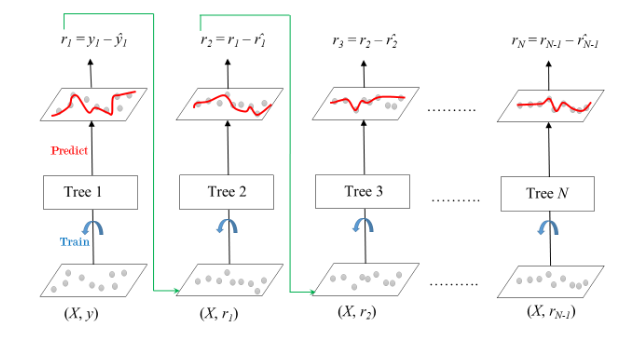
Illustration of a gradient boosting regression (_source: geeksforgeeks.org_)

Setting the following parameters of the model greatly improved our position on the leaderboard:
- *num_parallel_tree*: Setting this parameter to a number greater than 1 allows using random forest as base model;
- *monotone_constraints*: This can be used to enforce e.g. a positive constraint between number of dependent children and ultimate cost;
- *objective*: Changing the objective from naïve reg:squarederror to reg:gamma and reg:tweedie greatly improved results. The latter two objectives automatically use the log as link function.

## Feature importance

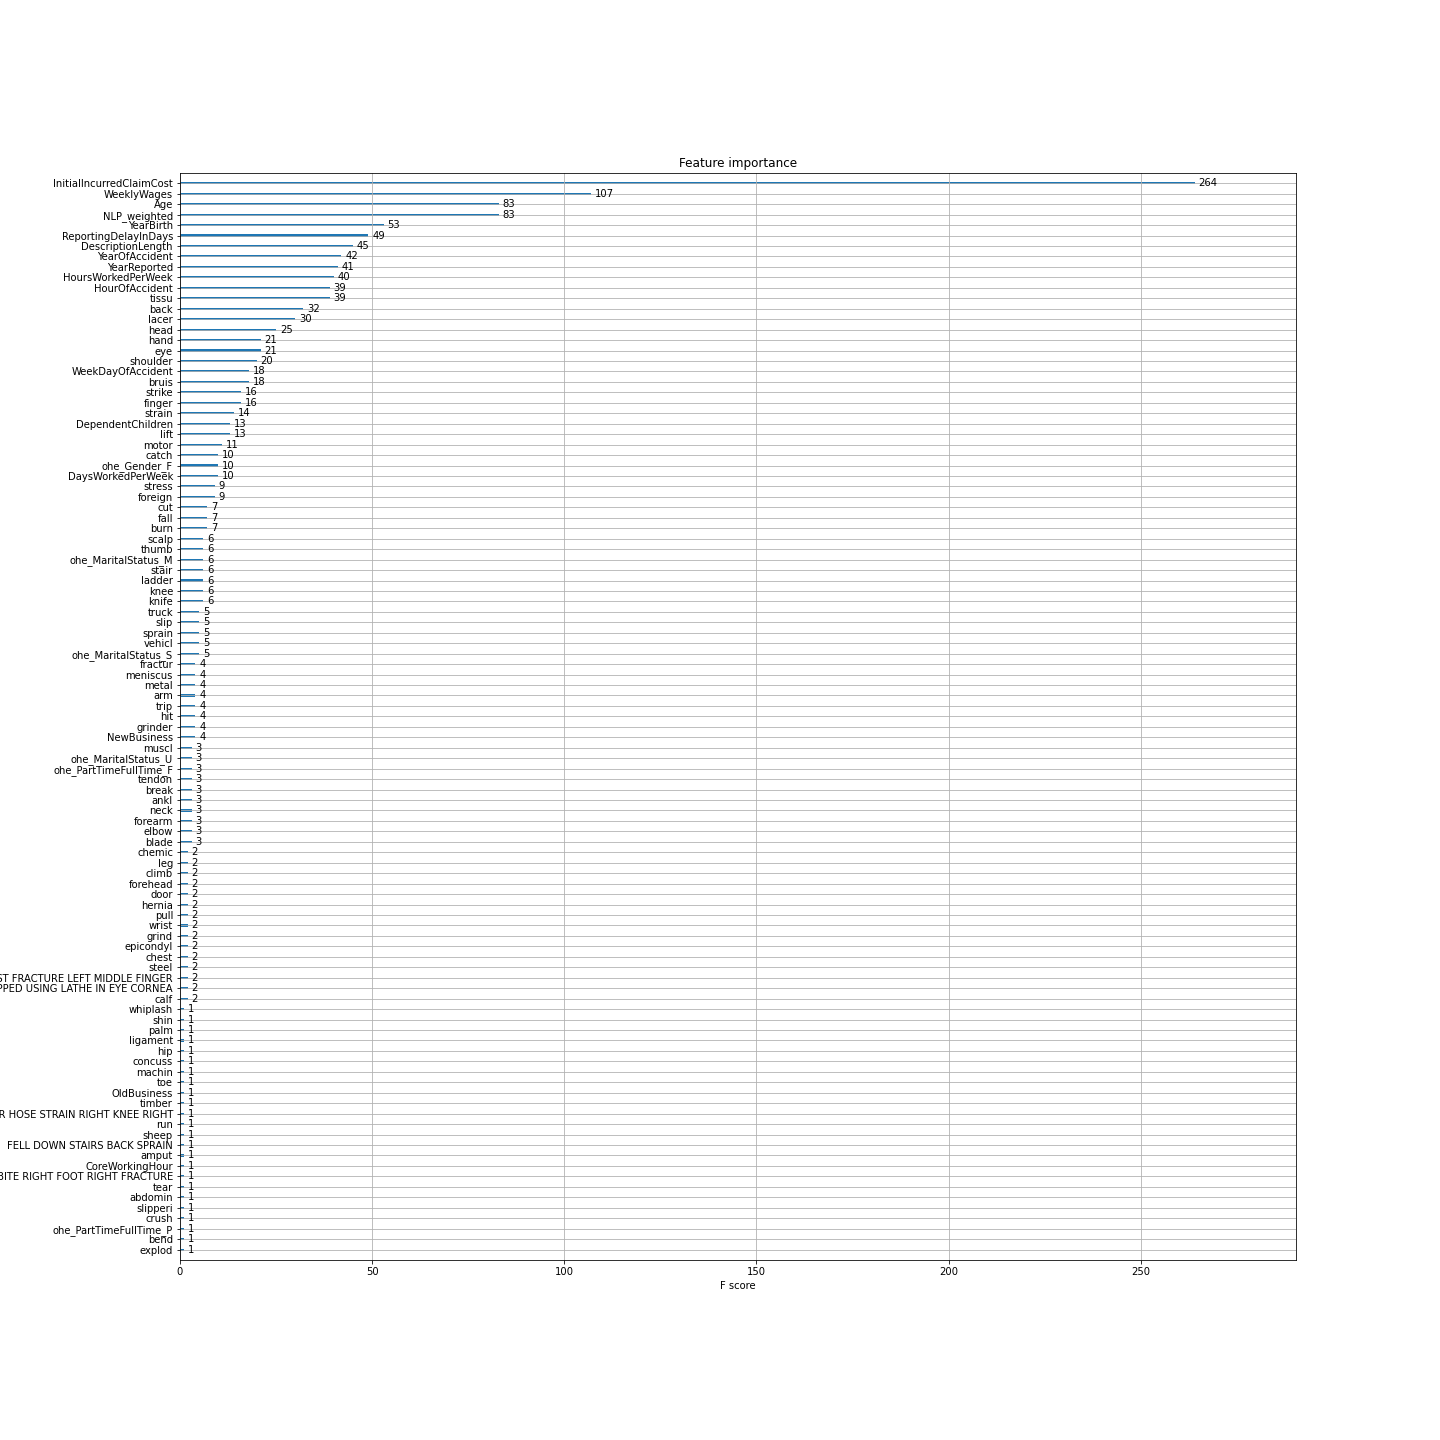

## Comparison of rmse descent

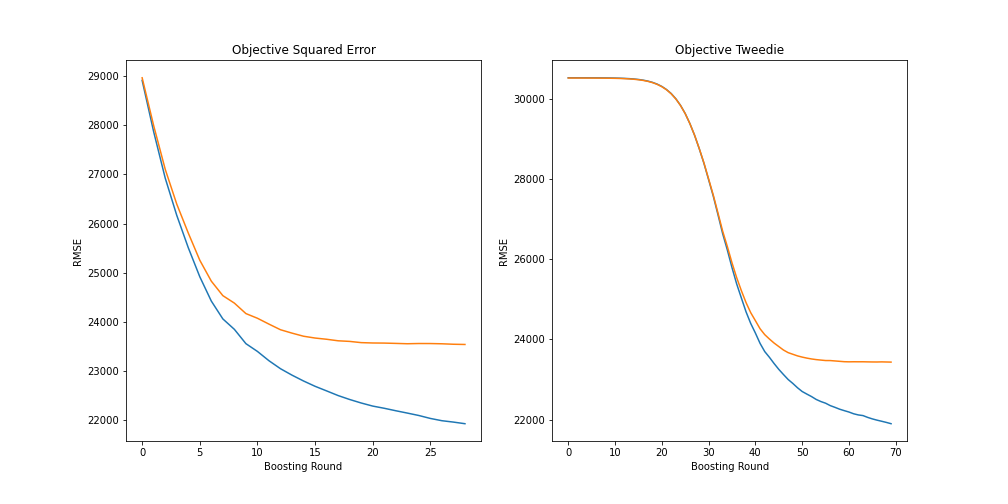

# Conclusions

The challenge was great fun!

Lessons learned:
- Feature engineering was more important than hyperparameter tuning;
- Our machines learnt but it was time-consuming to teach them!;
- Stacking seemed to result in overfitting;
- Neural networks are not a cure-all;

Thank you for your attention!